<img src="imgs/qiskit.png" alt="QisKit" style="width: 50px;" align="right"/>

# Shor's Algorithm

<hr>

## Teach Me Qiskit

## Introduction
   With accelerating computing power, breach of digital security might be viewed as a growing concern. 
   However, with current encryption methods utilizing prime factorizaiton, it will be a while before security is undermined 
   by classical computers.
   As a given number increases, the time it would take to calculate its prime factorization grows exponentially.
   Even with today's fastest computers, it would take thousands of years to generate the correct decryption keys. 
   However, with quantum computers and Shor's algorithm, this process can take seconds. 
 
   
   
   
   
    

### What is RSA Encryption?

Or Rivest-Shamir-Adleman Encryption, is used widely for secure data transmission. 
The encryption is asymmetric, which means that there are two keys inolved, one public and one private, for the encryption/decryption to work. 

Think of two complimentary colors:
    - if we combine them, we would get white.
    - however, retrieving two complimentary colors from white would be incredibly difficult unless a person has access
    to one of the colors

This is an intuitive, non-mathmetical way to think of how RSA works. 

####     Asymmetric Algorithm:
        - generates a public and private key 
        - used in the encryption and decryption of data

<hr>

<img src="imgs/rsa.png" alt="RSA Encryption" style="width: 500px;"/>

        - utilizes the fact that it is extremely hard to find the prime factors of a large composite (semiprime) number

<center>$a \times b = 6$</center>
        
        - labeled the "prime factorization problem"


The multiplication of these two numbers is _considerably_ more simple

#### Prime Numbers

<hr>

<img src="imgs/primes.png" alt="Prime Visual - Wikimedia Commons" style="width: 235px;"/>

<br>

|  Composite numbers  |  Prime numbers  |
|:---:|:---:|
|  1  |     |
|     |  2  |
|     |  3  |
|  4  |     |
|     |  5  |
|  6  |     |
|     |  7  |
|  8  |     |
|  9  |     |

In [3]:
a = 2
b = 3

print(f"{a} x {b} = {a * b}") # Demonstration of simple multiplication

2 x 3 = 6


#### Finding Primes

Sieve of Eratosthenes:  2000 year old bruteforce method for finding coprime numbers.
    
<img src="imgs/sieve.png" alt="Sieve of Eratosthenes" style="width: 400px;"/>

In [1]:
# import libraries we need
from math import gcd, sqrt, log, ceil # used in RSA and Shor's algorithm


from qiskit import * # importing qiskit tools
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua.algorithms import Shor


# API key to run our circuit on a real quantum computer
API_KEY = "ff7b7f43d8ed961867f6638374abf00274866beb9c65ff22dc8d77c57d82f6fa02dbc0280f9a9afaaaee5041ee56bb2c6ce0ffbe966a70a1f08f4cdb24f3bb1d"
IBMQ.save_account(API_KEY, overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'inline')

In [4]:
# https://www.geeksforgeeks.org/find-two-distinct-prime-numbers-with-given-product/

def Sieve_of_Eratosthenes(n, isPrime):
    isPrime[0], isPrime[1] = False, False
    for i in range(2, n + 1):
        isPrime[i] = True
    for p in range(2, int(sqrt(n)) + 1):
        if isPrime[p] == True:
            for i in range(p * 2, n + 1, p):
                isPrime[i] = False

def find_primes(n):
    isPrime = [False] * (n + 1)
    Sieve_of_Eratosthenes(n, isPrime)
    for i in range(2, n):
        x = int(n / i)
        if isPrime[i] & isPrime[x] and x != i and x * i == n:
            return i, x

In [5]:
c, d = find_primes(6)
print(f"{c} x {d} = {a * b}") # Demonstrate the difficulty in finding prime factors

2 x 3 = 6


#### RSA Algorithm Implementation

We can use two distinct primes to create a public and private key used to encrypt and decrypt respectively.

Let's use P and Q as our two distinct prime numbers

In [6]:
P = 3
Q = 11

#### What are public/ private keys?

Key Visual
<img src="imgs/keys.png" alt="Public/ Private Key Visual" style="width: 300px;"/>

Create a function to generate public and private RSA keys

In [7]:
def rsa(P, Q):
    N = P * Q # modulus <-- the hard number to crack!
    
    if N % 2 == 0:
        val = P if P % 2 == 0 else Q
        raise ValueError(f"{N} can not be divisible by 2. {P} and {Q} are incompatible with Shor's Algorithm.")
        
    
    L = (Q - 1) * (P - 1) # number of non-common factors (1, N)

    for E in range(2, L): # between (2, L)
        if gcd(L, E) * gcd(N, E) == 1: # coprime with both L and N
            break # E is public value

    D = 1
    while True:
        if D * E % L == 1 and D != E and D != N:
            break # D is private value
        D += 1

    return ((E, N), (D, N))

In [8]:
pub_key, priv_key = rsa(P, Q)
print("Public key:", pub_key) # Public key used for encryption
print("Private key:", priv_key)

Public key: (7, 33)
Private key: (3, 33)


We can now encrypt a super secret string

In [9]:
string = "qiskit"
string = string.upper()
print("Super secret string:", string)

inter = [ord(char)-ord('A') for char in string]

Super secret string: QISKIT


In [10]:
def enc(code, key):
    E, N = key
    return (code**E) % N

def dec(code, key):
    D, N = key
    return (code**D) % N

In [11]:
encoded = [enc(val, pub_key) for val in inter]
enc_str = "".join([chr(i+ord('A')) for i in encoded]) # Encrypted string
print("Encoded string:", enc_str)

Encoded string: ZCGKCN


In [12]:
decoded = [chr(dec(val, priv_key)+ord('A')) for val in encoded]
print("Decoded string:", ''.join(decoded))

Decoded string: QISKIT


*Keep in mind, this is a very simple and ineffective implementation of RSA encryption. The goal of this tutorial is to demonstrate Peter Shor's factoring algorithm applied to a situation not best RSA encryption practices.*

### Shor's Algorithm

<hr>

<img src="imgs/shors.png" alt="Prime Visual - Wikimedia Commons" style="width: 400px;"/>

Shor's Algorithm quickly determines two distinct prime numbers which multiply to produce a given number.

Let's assume we don't have access to the private key

Instead, all we have is the __encoded text__ and __public key__. Your mission, should you choose to accept it, is to find what the decoded text is with Shor's algorithm.

In [13]:
E, N = pub_key

print("You are assigned a mission on the following notecard:\n\n",
        f" {(18 + len(enc_str))*'_'}\n",
        "|", (16 + len(enc_str))*' ', "|\n",
        "| Decrypt this secret:", (len(enc_str) - 5)*' ', "|\n",
        "|", (16 + len(enc_str))*' ', "|\n",
        f"| Encoded string: {enc_str} |\n",
        f"| Public key: {pub_key}", ((18 + len(enc_str)) - (16 + len(str(pub_key))))*' ', " |\n",
        "|", (16 + len(enc_str))*' ', "|\n",
        f"|{(18 + len(enc_str))*'_'}|")

You are assigned a mission on the following notecard:

  ________________________
 |                        |
 | Decrypt this secret:   |
 |                        |
 | Encoded string: ZCGKCN |
 | Public key: (7, 33)    |
 |                        |
 |________________________|


In [14]:
def dec_guess(string, key):
    D, N = key
    return "".join([chr((((ord(char) - ord('A'))**D) % N) + ord('A')) for char in string])

Here we can observe that random guesses would be infeasible for larger primes

In [15]:
for i in range(5):
    print(dec_guess(enc_str, (i, N)))

BBBBBB
ZCGKCN
`EDBEE
QISKIT
EQJBQQ


#### Shor's Algorithm Attempt

In [16]:
ls = ceil(log(N**2, 2)) # Number of qubits required for the f-register
ms = ceil(log(N, 2)) # Number of qubits required for the x-register
qs = ls + ms
print(f"A quantum computer with {qs} qubits is required to factor {N}.")

A quantum computer with 17 qubits is required to factor 33.


In [17]:
# n = str(bin(N))[2:] # binary N

qr = QuantumRegister(qs)
cr = ClassicalRegister(qs)

circuit = QuantumCircuit(qr, cr)

In [18]:
# Qubit setup for Shor's algorithm
circuit.h(qr[:ls]) # put qubits into 2^8 states
circuit.x(qr[-1])
circuit.barrier()

# a^x % N

circuit.measure(qr, cr)

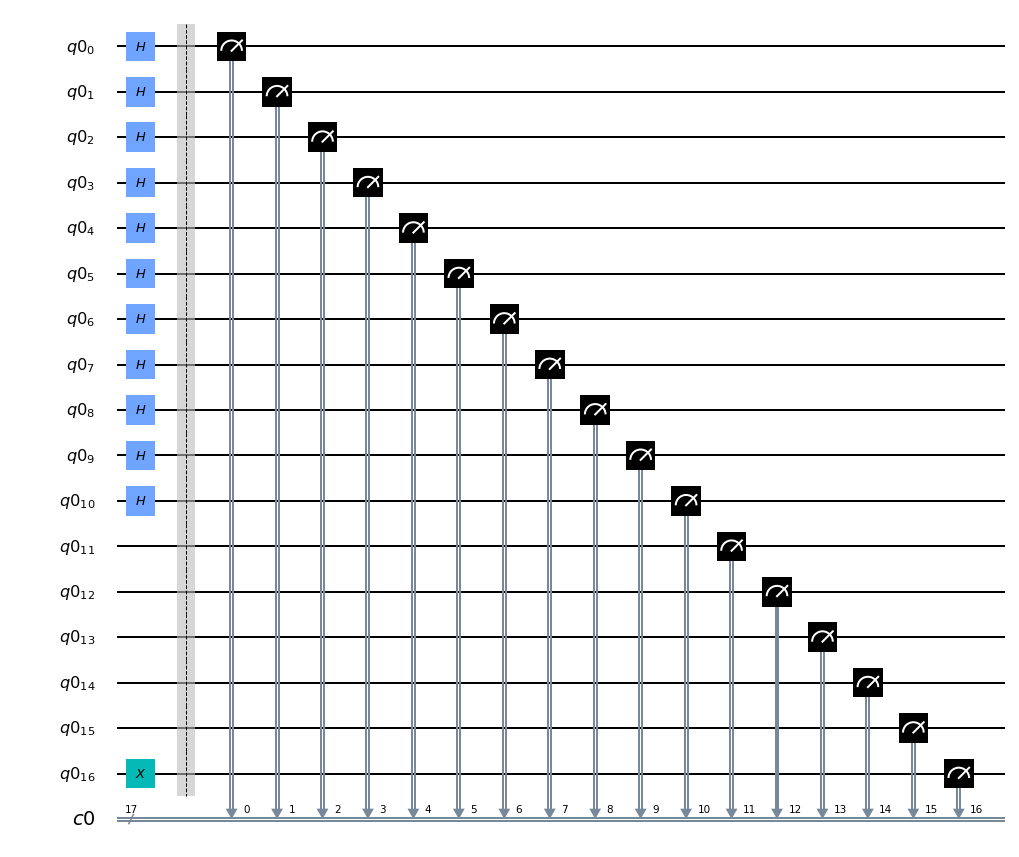

In [19]:
circuit.draw(output="mpl")

In [20]:
for a in range(2, N):
    if gcd(N, i) == 1:
        break

print("Guess =", a)

Guess = 2


#### Shor's Algorithm Library

In [21]:
# algorithm = Shor(N, a) # replicate this algo? or draw circuit and explain init, qft, and mod

# backend = Aer.get_backend("qasm_simulator")

# result = algorithm.run(backend)
# print(result.get("results"))

### Run Shor's Algorithm

Job Status: job has successfully run


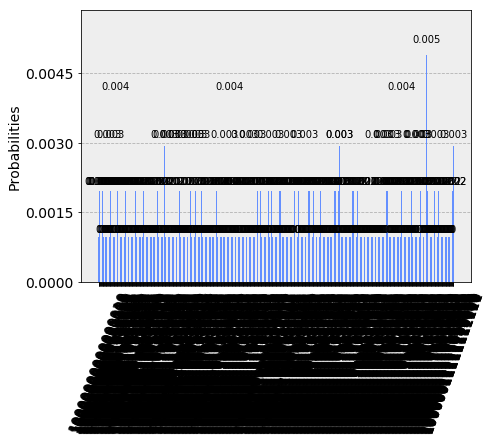

In [22]:
# backend = provider.get_backend("ibmq_qasm_simulator")
backend = Aer.get_backend("qasm_simulator")

job = execute(circuit, backend=backend)
job_monitor(job)

result = job.result()
plot_histogram(result.get_counts(circuit))